# Lecture 5: Generative models

In [8]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import warnings
warnings.filterwarnings('ignore')

In [9]:
(mnist_train,
 mnist_test) = [torchvision.datasets.MNIST(root='~/Dropbox/rutgers/teaching/msds-534-fall-2023/python/data',
                      train=train,
                      download=True,
                      transform=torchvision.transforms.ToTensor())
                for train in [True, False]]

In [10]:
train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=mnist_test, batch_size=64, shuffle=False)

In [11]:
class VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, loss_type='mse'):
        super(VAE, self).__init__()
        self.loss_type = loss_type
        self.q_z = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, hidden_dim),
                                 nn.ReLU())

        self.z_mean = nn.Linear(hidden_dim, latent_dim)
        self.z_log_var = nn.Linear(hidden_dim, latent_dim)

        self.generator = nn.Sequential(nn.Linear(latent_dim, hidden_dim),
                                       nn.ReLU(),
                                       nn.Linear(hidden_dim, hidden_dim),
                                       nn.ReLU(),
                                       nn.Linear(hidden_dim, input_dim))

    def encode(self, x):
        q_z = self.q_z(x)
        z_mean = self.z_mean(q_z)
        z_log_var = self.z_log_var(q_z)
        return z_mean, z_log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = mean + eps * std
        return sample

    def decode(self, z):
        x_reconstructed = self.generator(z)

        if self.loss_type == 'binary':
            x_reconstructed = F.sigmoid(x_reconstructed)

        return x_reconstructed
    
    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_mean = self.decode(z)
        # f_theta(z^l)
        return x_mean, z, z_mean, z_log_var

    def reconstruction_loss(self, x_pred, x):
        if self.loss_type == 'mse':
            loss = nn.MSELoss()
            reconstruction_loss = 0.5 * loss(x_pred, x)

        if self.loss_type == 'binary':
            reconstruction_loss = x * torch.log(x_pred + 1e-6) + \
                  (1-x) * torch.log(1 - x_pred + 1e-6)
            reconstruction_loss = -reconstruction_loss.sum(1).mean()

        return reconstruction_loss

    def vae_loss(self, x):

        x_mean, z, z_mean, z_log_var = self.forward(x)

        
        kld = 1 + z_log_var - z_mean.pow(2) - z_log_var.exp()
        kl_loss = -0.5 * torch.mean(kld)


        reconstruction_loss = self.reconstruction_loss(x_mean, x)

        return reconstruction_loss, kl_loss

In [14]:
input_dim = 28 * 28 # mnist pixels 28x28=784
hidden_dim = 300
latent_dim = 10

model = VAE(input_dim, latent_dim, hidden_dim, loss_type='binary')
lr = 1e-3
epochs = 50

optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

for epoch in range(epochs):

    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    for x_batch, y_batch in train_loader:

        x_batch = x_batch.reshape(x_batch.shape[0], 28*28)
        reconstruction_loss, kl_loss = model.vae_loss(x_batch)
        total_loss = reconstruction_loss + kl_loss

        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += total_loss.item()
        epoch_recon += reconstruction_loss.item()
        epoch_kl += kl_loss.item()

    epoch_loss = epoch_loss / len(train_loader)
    epoch_recon = epoch_recon / len(train_loader)
    epoch_kl = epoch_kl / len(train_loader)

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{epoch_loss:.3}", 'recon loss:', f"{epoch_recon:.3}",
              'kld:', f"{epoch_kl:.3}")



epoch:  0 loss: 1.41e+02 recon loss: 1.39e+02 kld: 2.63
epoch:  10 loss: 82.2 recon loss: 78.9 kld: 3.3
epoch:  20 loss: 79.3 recon loss: 76.0 kld: 3.32
epoch:  30 loss: 78.0 recon loss: 74.7 kld: 3.33
epoch:  40 loss: 77.1 recon loss: 73.8 kld: 3.35


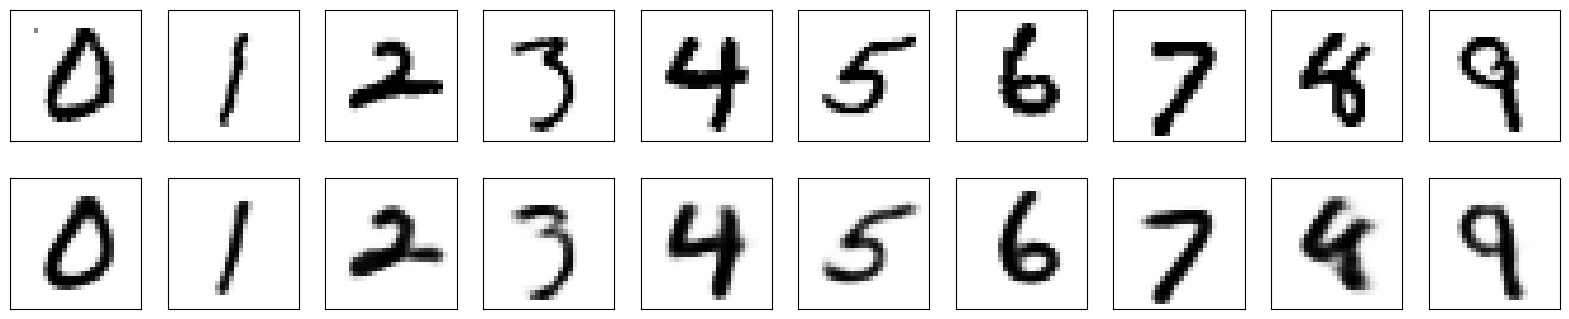

In [15]:
model.eval()

n_img = 10
num_cols = 5
num_rows = 2
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(n_img):

  inds = torch.where(mnist_test.test_labels == i)[0].numpy()
  ind = np.random.choice(inds)

  x, label = mnist_test[ind]
  x_batch = x.reshape(x.shape[0], 28*28)

  x_mean, z, z_mean, z_log_var = model(x_batch)
  x_recon = x_mean.reshape((28,28))

  plt.subplot(num_rows, 2 * num_cols, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x[0].detach().cpu().numpy(), cmap=plt.cm.binary)

  plt.subplot(num_rows, 2 * num_cols, (i + 1) + 2 * num_cols)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_recon.detach().cpu().numpy(), cmap=plt.cm.binary)


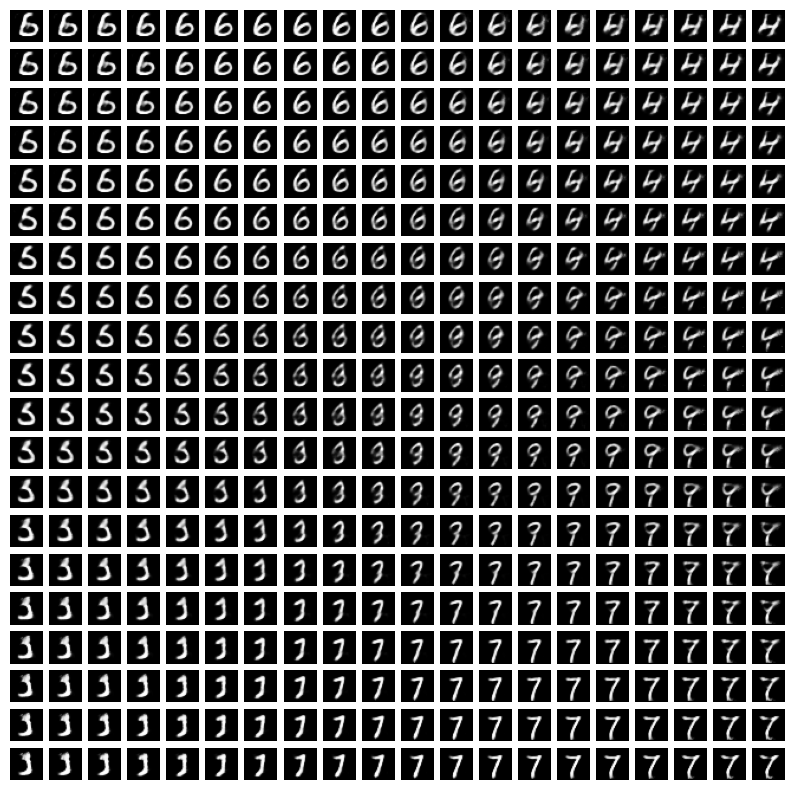

In [8]:
# Create a grid of latent vectors for traversal
n_samples = 20
grid_x = np.linspace(-3, 3, n_samples)
grid_y = np.linspace(-3, 3, n_samples)
traversal_grid = torch.FloatTensor(n_samples, n_samples, 10)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = torch.FloatTensor([[0, 0, 0, xi, yi, 0, 0, 0, 0, 0]])
        traversal_grid[j, i] = z_sample

# Generate images from the latent traversal grid
with torch.no_grad():
    traversal_grid = traversal_grid.view(-1, 10)
    generated_images = model.decode(traversal_grid).view(-1, 1, 28, 28)

# Plot the generated images
plt.figure(figsize=(10, 10))
for i in range(n_samples):
    for j in range(n_samples):
        plt.subplot(n_samples, n_samples, i * n_samples + j + 1)
        plt.imshow(generated_images[i * n_samples + j].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')

plt.show()

# latent traversal plots

In [16]:
labels = mnist_test.test_labels
labels = labels.numpy()
labels = labels.reshape(-1, 1)

In [20]:
x_test = mnist_test.data
x_test = x_test.reshape(x_test.shape[0], 28*28)
x_test = x_test.to(torch.float) 

In [22]:
z_test, _ = model.encode(x_test)
z_np = z_test.detach().numpy()

In [23]:
df = pd.DataFrame(z_np, columns = ['z' + str(i+1) for i in range(z_np.shape[1])])
df['label'] = labels
df['label'] = df['label'].astype('category')

<Axes: xlabel='z1', ylabel='z2'>

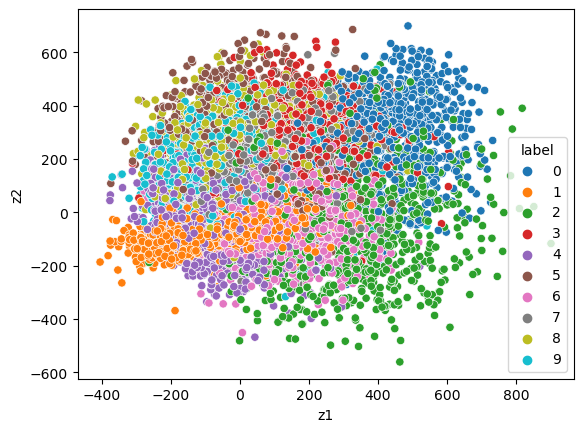

In [24]:
# Create a scatter plot with colored clusters
sns.scatterplot(x='z1', y='z2', hue='label', data=df)


In [6]:
# quick example of transpose

X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(in_channels=1, 
                           out_channels=1, 
                           kernel_size=2, 
                           stride=1, 
                           padding=0, 
                           output_padding=0,
                           bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)